# Steam Image Search

Reference: https://github.com/woctezuma/steam-image-search

## Install requirements

In [1]:
%pip install ftfy faiss-gpu > /dev/null

In [2]:
!git clone https://github.com/openai/CLIP.git
%mv CLIP/*.py .
%mv CLIP/*.gz .

Cloning into 'CLIP'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.


## Download data

In [3]:
from pathlib import Path

if not Path('app_ids.txt').exists():
  !gdown --id 1iNgl_3AJotauknzb-La9Dsw8h3I7QQYh -O app_ids.txt

if not Path('image_features.npy').exists():
  !gdown --id 1sqtttJ4eghHY4PicSy5uCHhniyfFLLpv -O image_features.npy

Downloading...
From: https://drive.google.com/uc?id=1iNgl_3AJotauknzb-La9Dsw8h3I7QQYh
To: /content/app_ids.txt
100% 227k/227k [00:00<00:00, 7.19MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sqtttJ4eghHY4PicSy5uCHhniyfFLLpv
To: /content/image_features.npy
123MB [00:01, 109MB/s]


In [4]:
with open('app_ids.txt', 'r') as f:
  app_ids = [int(app_id.strip()) for app_id in f.readlines()]

In [5]:
import numpy as np

image_features = np.load("image_features.npy")

## Define functions



In [6]:
import faiss

def build_index(xb):
    xb = xb.astype('float32')
    faiss.normalize_L2(xb)

    index = faiss.IndexFlatIP(xb.shape[1])
    index.add(xb)

    return index

def find_knn(xq, index, n):
  xq = xq.astype('float32')
  faiss.normalize_L2(xq)

  D, I = index.search(xq, n)

  return I

In [7]:
import torch
import clip

def match_text(text_query, index, ids, num_matches = 24):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model, _ = clip.load("ViT-B/32", device=device)

  text_input = clip.tokenize(text_query).to(device)  
  with torch.no_grad():
      text_features = model.encode_text(text_input)  
  xq = text_features.cpu().numpy()

  I = find_knn(xq, index, num_matches)

  return [ids[i] for i in I[0]]

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

def get_url(id):
  return f'https://cdn.cloudflare.steamstatic.com/steam/apps/{id}/library_600x900.jpg'

def show_image_grid(ids, num_rows = 4, width = 12):
  # Reference: https://stackoverflow.com/a/36049914/376454

  num_cols = int((len(ids)+1)/num_rows)
  num_cols = max(1, num_cols)

  fig = plt.figure(figsize=(width,width)) # Notice the equal aspect ratio
  ax = [fig.add_subplot(num_rows, num_cols, i+1) for i in range(len(ids))]

  for i, a in enumerate(ax):
      im = Image.open(requests.get(url=get_url(ids[i]), stream=True).raw)
      a.imshow(im)
      a.set_xticklabels([])
      a.set_yticklabels([])
      a.set_aspect('equal')      

  fig.subplots_adjust(wspace=0, hspace=0)

  return

In [9]:
def process(text, index=None):
  if index is None:
    index = build_index(image_features)

  ids = match_text(text, index, app_ids)

  print(f'Query: {text}')
  show_image_grid(ids, width=12)

  return

## Search for images

In [10]:
index_knn = build_index(image_features)

Query: A dog plays with a  cat


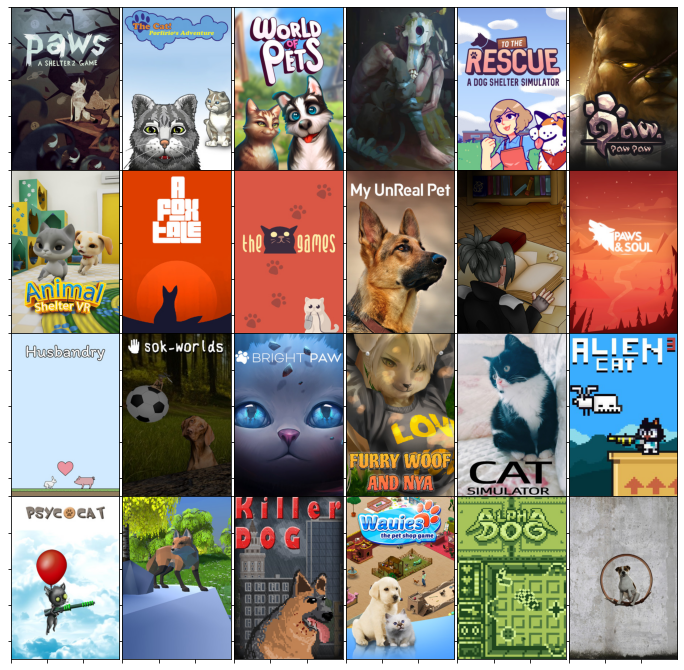

In [15]:
text = "A dog plays with a cat"
process(text, index=index_knn)

100%|██████████████████████| 353976522/353976522 [00:02<00:00, 134698098.61it/s]


Query: A woman with blue hair wears glasses


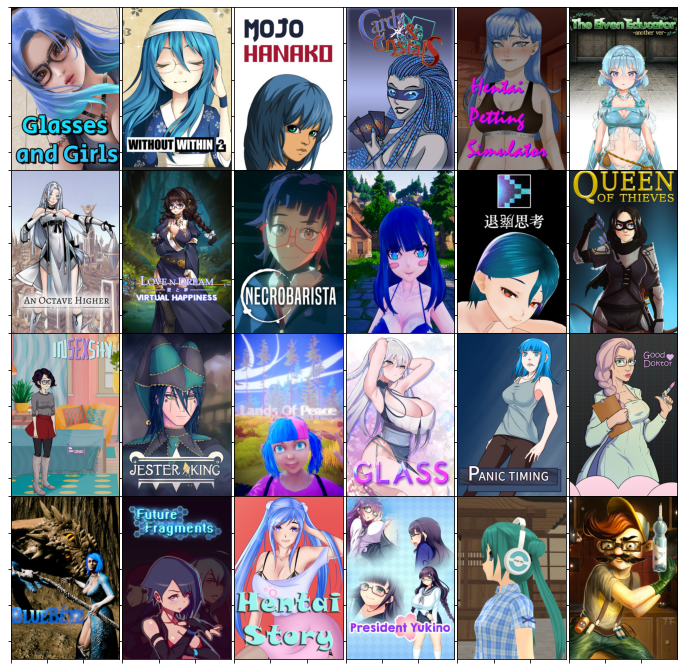

In [11]:
text = "A woman with blue hair wears glasses"
process(text, index=index_knn)

Query: A nerdy white man looks at a screen


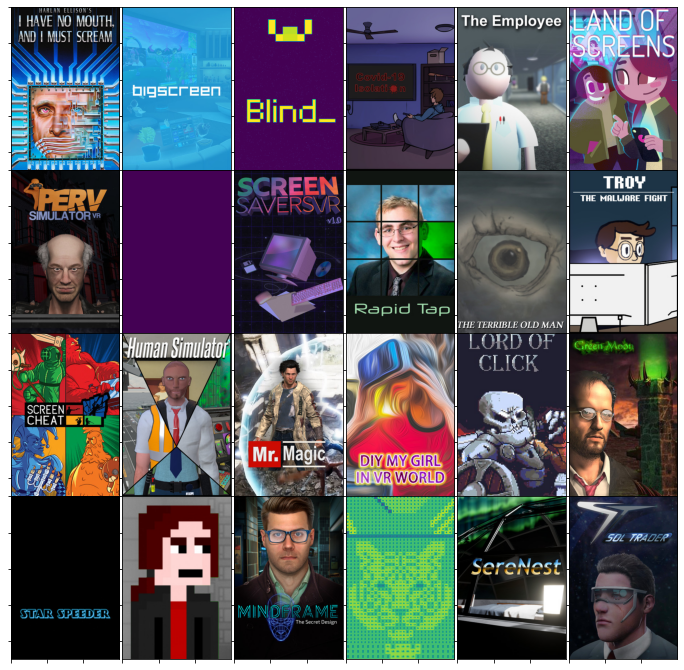

In [13]:
text = "A nerdy white man looks at a screen"
process(text, index=index_knn)

Query: A cat smiles at a person


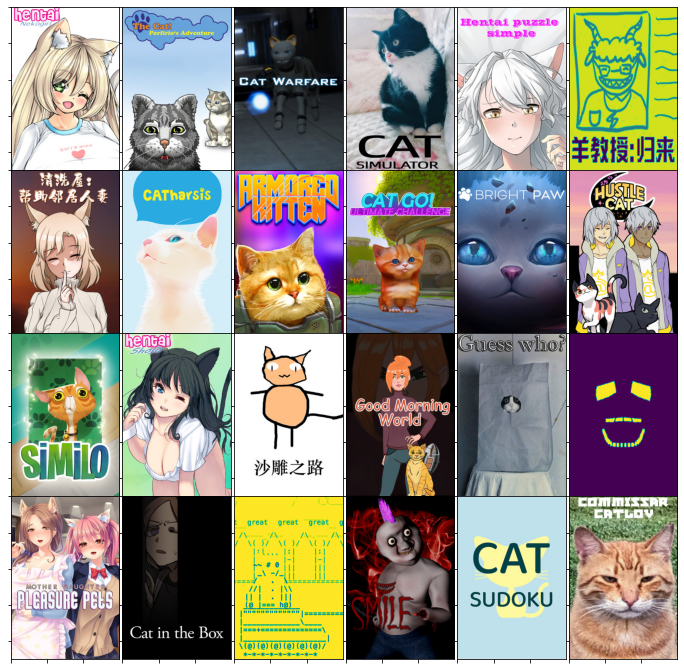

In [14]:
text = "A cat smiles at a person"
process(text, index=index_knn)

Query: A woman with blonde hair wears tight shorts


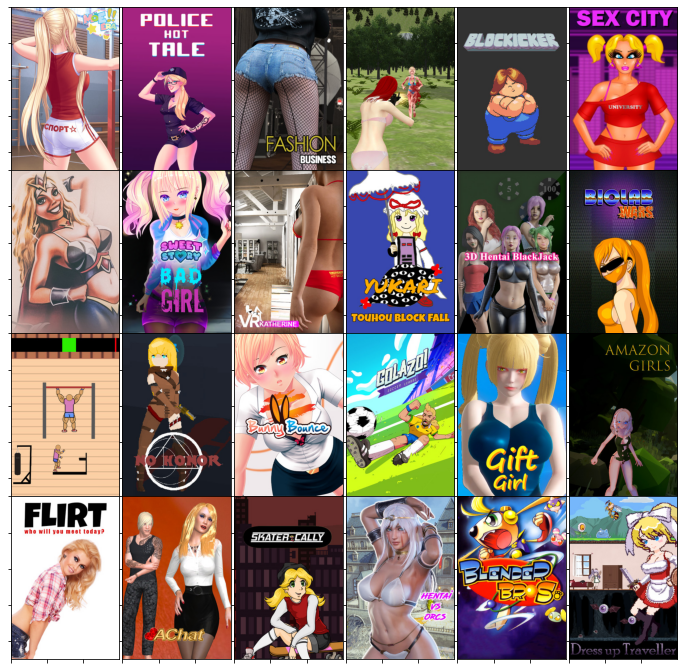

In [12]:
text = "A woman with blonde hair wears tight shorts"
process(text, index=index_knn)

Done.